# Определение возраста человека по фотографии

### Цель

На основе датасета из более 7тыс. фотографий людей построить модель ML для определения их возраста. Результаты будут использованы для:
- контроля продажи алкоголя на кассе магазина
- рекомендательной системы товаров по возрастным группам

### План действий

- анализ датасета: диапазон возрастов, характеристики фотографий, аномалии
- построение модели (выбор оптимальных гиперпараметров) ML и её анализ

## Исследовательский анализ данных

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels[:2]

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18


In [3]:
#~7.5тыс записей, от 0 до 100 лет
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

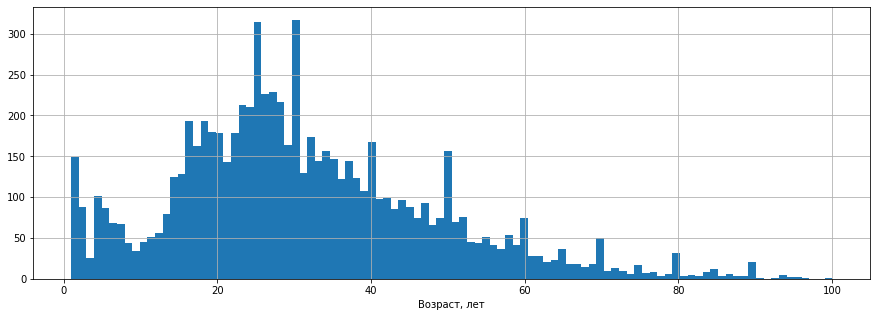

In [4]:
#наблюдаются пики круглых возрастов
#много детей
labels.real_age.hist(figsize=(15,5),bins=100)
plt.xlabel('Возраст, лет')
plt.show()

In [5]:
#минимальный и максимальный размер фотографий
file_names=labels['file_name']
width=set()
height=set()
for file_name in file_names:
    img=image.imread('/datasets/faces/final_files/'+file_name)
    height.add(img.shape[0])
    width.add(img.shape[1])
    
print('Resolution:')    
print('min:', min(height), min(width))
print('max:', max(height), max(width))

Resolution:
min: 47 47
max: 4466 4466


In [6]:
#генератор фотографий из датасета (для отображения их примера), ресайз до 224х224px
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels[:500],
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 500 validated image filenames.


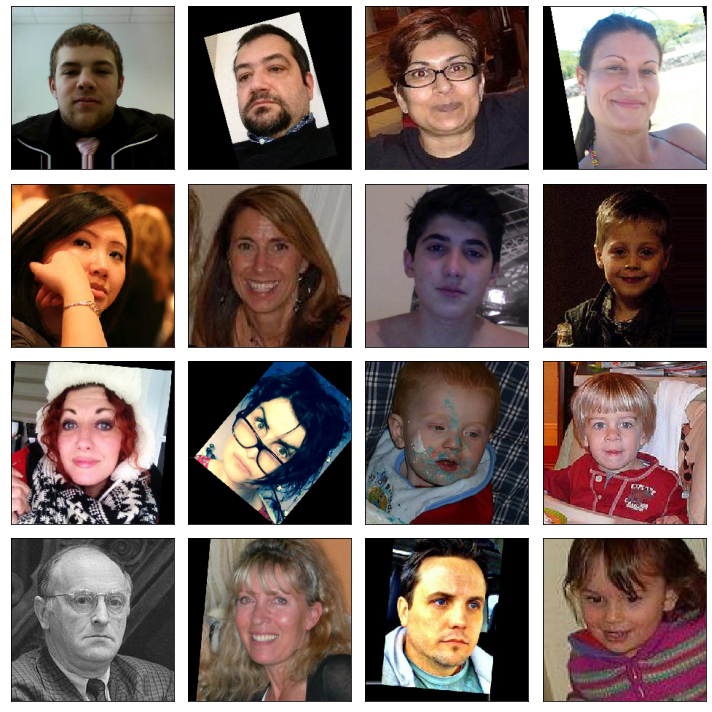

In [7]:
#примеры фотографий
features=next(train_gen_flow)[0]
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- датасет из более 7тыс. фотографий людей
- распределение возраста близко к нормальному, с медианой в 29лет и повышенным содержанием младенцев и "круглых" возрастов. Последнее может быть связано с отсутствием данных по возрасту при разметке датасета
- фотографии в основном с соотношением 1:1, разрешение разнится от 47 до 4466 пикселей, встречаются чёрно-белые
- ориентация в основном вертикальная, может присутствовать наклон больше 30 градусов
- есть аномалии: отсутствие лица, несколько лиц, фото издалека, - что может ухудшить качество модели
- для улучшения качества модели можно провести аугментацию: отразить фотографии вертикально, сдвинуть по вертикали и горизонтали, немного повернуть (до 20 градусов)

## Построение модели

In [8]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25, 
                                       horizontal_flip=True, rotation_range=20, 
                                       width_shift_range=.2, height_shift_range=.2)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, 
                batch_size=None, epochs=10, steps_per_epoch=None, 
                validation_steps=None):
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
"""
if __name__ == '__main__':
    path = '/datasets/faces/'
    train_data = load_train(path=path)
    test_data = load_test(path=path)
    input_shape = train_data[0][0].shape[1:]
    model = create_model(input_shape=input_shape)
    model = train_model(model, train_data, test_data, 
                        steps_per_epoch=len(train_data), 
                        validation_steps=len(test_data), 
                        epochs=10)
    mse, mae = model.evaluate(test_data, verbose=2)
    print(f'MAE: {mae}')
"""

"\nif __name__ == '__main__':\n    path = '/datasets/faces/'\n    train_data = load_train(path=path)\n    test_data = load_test(path=path)\n    input_shape = train_data[0][0].shape[1:]\n    model = create_model(input_shape=input_shape)\n    model = train_model(model, train_data, test_data, \n                        steps_per_epoch=len(train_data), \n                        validation_steps=len(test_data), \n                        epochs=10)\n    mse, mae = model.evaluate(test_data, verbose=2)\n    print(f'MAE: {mae}')\n"

## Анализ модели

Test MAE: 6.2825

Модель нужна для: 
- недопущения продажи алкоголя молодым
- предложения покупателям популярных товаров в соответствии с их возрастными группами

`MAE = 6.3` - полученное качество модели на тестовой выборке. 
- покупателей, предполагаемый возраст которых определён как меньше 25, нужно просить показать паспорт
- покупателям на границе возрастных групп (+-6 лет) можно рекомендовать товары, популярные в этих двух группах


Для уменьшения ошибки определения возраста в рамках преследуемых целей можно:
- добавить в датасет больше фотографий подростков и пенсионеров
- убрать фотографии младенцев из датасета, т.к. такие покупатели в магазине крайне маловероятны
- заново сформировать датасет только из фотографий, возраст людей на которых достоверно известен, а не размечен "круглым" числом из-за отсутствия информации

Использованы:
- аугментация данных (небольшие повороты, сдвиги и горизонтальное отражение фотографий)
- нейросеть типа ResNet50
    - с начальными весами `imagenet`
    - алгоритмом оптимизации `Adam` с шагом `0.0001`
    - `MSE` функцией потерь
    - `10` эпохами обучения